# Show And Tell with Flickr8k using PyTorch
## 1 Preparation
### 1.1 Import Libraries

In [1]:
import os
import io
import numpy as np
import time
import random
import warnings
warnings.filterwarnings("ignore")

from itertools import chain
from matplotlib import pyplot as plt
from nltk import word_tokenize
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 1.2 Resize Images

In [2]:
image_dir = './Flickr8k/Flickr8k_Dataset/'
output_dir = './Flickr8k/Flickr8k_resized_image/'
image_size = [256,256]

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

images = os.listdir(image_dir)
num_images = len(images)
for i, image in enumerate(images):
    with open(os.path.join(image_dir, image), 'r+b') as f:
        with Image.open(f) as img:
            img = img.resize(image_size, Image.ANTIALIAS)
            img.save(os.path.join(output_dir, image), img.format)
            
    if (i+1) % 1000 == 0:
        print ("[{}/{}] images are resized and saved into '{}'."
               .format(i+1, num_images, output_dir))

[1000/8091] images are resized and saved into './Flickr8k/Flickr8k_resized_image/'.
[2000/8091] images are resized and saved into './Flickr8k/Flickr8k_resized_image/'.
[3000/8091] images are resized and saved into './Flickr8k/Flickr8k_resized_image/'.
[4000/8091] images are resized and saved into './Flickr8k/Flickr8k_resized_image/'.
[5000/8091] images are resized and saved into './Flickr8k/Flickr8k_resized_image/'.
[6000/8091] images are resized and saved into './Flickr8k/Flickr8k_resized_image/'.
[7000/8091] images are resized and saved into './Flickr8k/Flickr8k_resized_image/'.
[8000/8091] images are resized and saved into './Flickr8k/Flickr8k_resized_image/'.


### 1.3 Text Preprocessing

In [3]:
train_image_list=[]
with open('./Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt','r') as f:
    for image in f:
        train_image_list.append(image.strip())
        
val_image_list=[]
with open('./Flickr8k/Flickr8k_text/Flickr_8k.devImages.txt','r') as f:
    for image in f:
        val_image_list.append(image.strip())
        
test_image_list=[]
with open('./Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt','r') as f:
    for image in f:
        test_image_list.append(image.strip())
        
image_caption=[]
with open('./Flickr8k/Flickr8k_text/Flickr8k.token.txt','r') as f:
    for image in f:
        image_caption.append(image)

In [4]:
annot={}
for i in range(0, len(image_caption), 5):
    ann=[]
    t1=image_caption[i].strip()
    for j in range(i,i+5):
        tmp=image_caption[j].strip()
        tmp=tmp.split('\t')
        ann.append([tmp[1].lower()])
    t1=t1.split('\t')
    annot[t1[0].split('#')[0]]=ann

In [5]:
cap_dict={}
for i in range(0, len(image_caption), 5):
    tmp=image_caption[i].strip()
    tmp=tmp.split('\t')
    cap_dict[tmp[0].split('#')[0]]=tmp[1].lower()

In [6]:
train_cap_dict={}
for image in train_image_list:
    train_cap_dict[image]=cap_dict[image]
    
val_cap_dict={}
for image in val_image_list:
    val_cap_dict[image]=cap_dict[image]
    
test_cap_dict={}
for image in test_image_list:
    test_cap_dict[image]=cap_dict[image]

In [7]:
train_token=[]
train_tok=[]
val_token=[]
test_token=[]

for (j,i) in train_cap_dict.items():
    train_token.append([j, word_tokenize(i)])
    train_tok.append(word_tokenize(i))
    
for (j,i) in val_cap_dict.items():
    val_token.append([j, word_tokenize(i)])
    
for (j,i) in test_cap_dict.items():
    test_token.append([j, word_tokenize(i)])

In [8]:
tokens = chain.from_iterable(train_tok)
word2idx = {token: idx for idx, token in enumerate(set(tokens))}

tokens = chain.from_iterable(train_tok)
idx2word = [token for idx, token in enumerate(set(tokens))]
idx2word = np.asarray(idx2word)

In [9]:
train_token_ids = [[word2idx[token] for token in x[1]] for x in train_token]
count = np.zeros(idx2word.shape)

for x in train_token_ids:
    for token in x:
        count[token] += 1
        
indices = np.argsort(-count)
idx2word = idx2word[indices]
count = count[indices]

In [10]:
word2idx = {token: idx for idx, token in enumerate(idx2word)}
print("Vocabulary size: "+str(len(word2idx)))

Vocabulary size: 3890


In [11]:
train_token_ids = [[word2idx.get(token, -4) +4 for token in x[1]] for x in train_token]
val_token_ids = [[word2idx.get(token, -4) +4 for token in x[1]] for x in val_token]
test_token_ids = [[word2idx.get(token, -4) +4 for token in x[1]] for x in test_token]

In [12]:
word2idx['<unknown>'] = -4
word2idx['<start>'] = -3
word2idx['<end>'] = -2
word2idx['<pad>'] = -1

for (_, i) in word2idx.items():
    i+=4
    word2idx[_] = i

idx2word_dict={}
cnt=4

for i in idx2word:
    idx2word_dict[cnt]=i
    cnt+=1
    
idx2word_dict[0]='<unknown>'
idx2word_dict[1]='<start>'
idx2word_dict[2]='<end>'
idx2word_dict[3]='<pad>'

train_cap_length={}
for i in train_token:
    train_cap_length[i[0]]=len(i[1])+2
    
val_cap_length={}
for i in val_token:
    val_cap_length[i[0]]=len(i[1])+2
    
test_cap_length={}
for i in test_token:
    test_cap_length[i[0]]=len(i[1])+2

In [13]:
for i in train_token_ids:
    i.insert(0, word2idx['<start>'])
    i.append(word2idx['<end>'])

for i in val_token_ids:
    i.insert(0, word2idx['<start>'])
    i.append(word2idx['<end>'])
    
for i in test_token_ids:
    i.insert(0, word2idx['<start>'])
    i.append(word2idx['<end>'])

In [14]:
length=[]

for (i, j) in train_cap_length.items():
    length.append(j)

for n, i in enumerate(train_token):
    if (train_cap_length[i[0]] < max(length)):
        train_token_ids[n].extend(word2idx['<pad>'] for i in range(train_cap_length[i[0]], max(length)))
        
train_token_ids_dict={}

for n, i in enumerate(train_token):
    train_token_ids_dict[i[0]]=train_token_ids[n]

In [15]:
length=[]

for (i, j) in val_cap_length.items():
    length.append(j)

for n,i in enumerate(val_token):
    if (val_cap_length[i[0]] < max(length)):
        val_token_ids[n].extend(word2idx['<pad>'] for i in range(val_cap_length[i[0]], max(length)))
        
val_token_ids_dict={}

for n,i in enumerate(val_token):
    val_token_ids_dict[i[0]]=val_token_ids[n]

In [16]:
length=[]

for (i,j) in test_cap_length.items():
    length.append(j)
max_len=max(length)

for n,i in enumerate(test_token):
    if (test_cap_length[i[0]] < max(length)):
        test_token_ids[n].extend(word2idx['<pad>'] for i in range(test_cap_length[i[0]], max(length)))
        
test_token_ids_dict={}

for n,i in enumerate(test_token):
    test_token_ids_dict[i[0]]=test_token_ids[n]

In [17]:
np.save('./Flickr8k/Flickr8k_text/flickr8k_dictionary.npy',np.asarray(idx2word))

In [18]:
with io.open('./Flickr8k/Flickr8k_text/train_captions.txt', 'w', encoding='utf-8') as f:
    for i, tokens in enumerate(train_token_ids):
        f.write("%s " % train_token[i][0])
        for token in tokens:
            f.write("%i " % token)
        f.write("\n")
        
with io.open('./Flickr8k/Flickr8k_text/val_captions.txt', 'w', encoding='utf-8') as f:
    for i, tokens in enumerate(val_token_ids):
        f.write("%s " % val_token[i][0])
        for token in tokens:
            f.write("%i " % token)
        f.write("\n")

with io.open('./Flickr8k/Flickr8k_text/test_captions.txt', 'w', encoding='utf-8') as f:
    for i, tokens in enumerate(test_token_ids):
        f.write("%s " % test_token[i][0])
        for token in tokens:
            f.write("%i " % token)
        f.write("\n")

In [19]:
checkpoints = './Flickr8k/Flickr8k_checkpoints/'
results = './Flickr8k/Flickr8k_results/'

In [20]:
if not os.path.exists(checkpoints):
    os.mkdir(checkpoints)

In [21]:
if not os.path.exists(results):
    os.mkdir(results)

## 2. Flickr8k Dataset

In [22]:
class Flickr8k(Dataset):
    def __init__(self, image_list, cap_dictionary, cap_length, transform=None):
        
        self.image_path='./Flickr8k/Flickr8k_resized_image/'
        self.image_list=image_list
        self.transform=transform
        self.cap_dictionary=cap_dictionary
        self.cap_length=cap_length
    
    def __getitem__(self, index):
        image=self.image_list[index]
        img_open=Image.open(self.image_path+image).convert('RGB')
        
        if self.transform is not None:
            img_open=self.transform(img_open)
        
        caption = np.array(self.cap_dictionary[image])
        lengths = self.cap_length[image]
        
        return img_open, caption, lengths
        
    def __len__(self):
        return len(self.image_list)

In [23]:
def get_flickr8k_loader(purpose, batch_size):
    
    if purpose not in ['train', 'val', 'test']:
        raise NameError('Purpose should be train, val or test.')
    
    if purpose == 'train':
        transform = transforms.Compose([transforms.RandomCrop(224),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        
        train_data=Flickr8k(train_image_list, train_token_ids_dict, train_cap_length, transform)
        train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=True)
        return train_loader
        
    elif purpose == 'val':
        transform = transforms.Compose([transforms.RandomCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        
        val_data=Flickr8k(val_image_list, val_token_ids_dict, val_cap_length, transform)
        val_loader=DataLoader(val_data, batch_size=batch_size, shuffle=True)
        return val_loader
    
    elif purpose == 'test':
        transform = transforms.Compose([transforms.RandomCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        
        test_data=Flickr8k(test_image_list, test_token_ids_dict, test_cap_length, transform)
        test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=True)
        return test_loader

In [24]:
batch_size = 32

train_loader = get_flickr8k_loader('train', batch_size)
val_loader = get_flickr8k_loader('val', batch_size//6)
test_loader = get_flickr8k_loader('test', batch_size//6)

## 3. Models
### 3.1 Encoder CNN

In [25]:
class EncoderCNN(nn.Module):
    def __init__(self, encoder_model, embed_size):
        super(EncoderCNN, self).__init__()
        
        if encoder_model == 'VGG19':
            vgg19 = models.vgg19_bn(pretrained=True)
            modules = list(vgg19.children())[:-1]
            self.vgg = nn.Sequential(*modules)
            self.linear = nn.Linear(vgg19.classifier[0].in_features, embed_size)
        
        elif encoder_model == 'ResNet152':
            resnet = models.resnet152(pretrained=True)
            modules = list(resnet.children())[:-1]  # delete the last fc layer.
            self.resnet = nn.Sequential(*modules)
            self.linear = nn.Linear(resnet.fc.in_features, embed_size)
            
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        self.init_weights()

    def init_weights(self):
        self.linear.weight.data.normal_(0.0, 0.02)
        self.linear.bias.data.fill_(0)

    def forward(self, images):
        with torch.no_grad():
            features = self.vgg(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features

### 3.2 Decoder RNN

In [26]:
class DecoderRNN(nn.Module):
    def __init__(self, decoder_model, vocab_size, embed_size, hidden_size, num_layers, max_seq_length=20):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        
        if decoder_model == "LSTM":
            self.rnn = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        elif decoder_model == "GRU":
            self.rnn = nn.GRU(embed_size, hidden_size, num_layers, batch_first=True)
            
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions.long())
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.rnn(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.rnn(inputs, states)           # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [27]:
vocab_size = len(word2idx)
embed_dim = 512
hidden_dim = 512
num_layers = 1

encoder = EncoderCNN("VGG19", embed_dim).to(device)
decoder = DecoderRNN("GRU", vocab_size, embed_dim, hidden_dim, num_layers).to(device)

In [28]:
training_losses, val_losses, test_losses = [], [], []
bleu1_list, bleu2_list, bleu3_list, bleu4_list = [], [], [], []

## 4. Utils

In [29]:
def sorting(image,caption,length):
    srt=length.sort(descending=True)
    image=image[srt[1]]
    caption=caption[srt[1]]
    length=srt[0]
    return image, caption, length

In [30]:
def sentence_generation(image, encoder, decoder):

    image = image.to(device)
    feature = encoder(image)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()
    caption = []
    
    for idx in sampled_ids:
        word = idx2word_dict[idx]
        caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(caption)
    
    return sentence

In [31]:
def load_image(image_path):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)
    
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    image = transform(image).unsqueeze(0)
    
    return image

In [32]:
def getRandomFile(img_list):
    index = random.randrange(0, len(img_list))
    return img_list[index]

In [33]:
def plot_losses(losses1, losses2, model):
    plt.figure(figsize=(5, 5))
    plt.plot(losses1, label='Train', marker='o', alpha=0.5)
    plt.plot(losses2, label='Validation', marker='o', alpha=0.5)
    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.legend()
    plt.grid(b=True)
    plt.title('Show And Tell Losses with {}'.format(model.__class__.__name__))
    plt.savefig('./Flickr8k/Flickr8k_results/Show And Tell Losses with {}.png'.format(model.__class__.__name__))
    plt.show()

In [34]:
def plot_bleu(bleu1, bleu2, bleu3, bleu4, model):
    plt.figure(figsize=(5, 5))
    plt.plot(bleu1_list, label='BLEU 1', marker='o', alpha=0.5)
    plt.plot(bleu2_list, label='BLEU 2', marker='o', alpha=0.5)
    plt.plot(bleu3_list, label='BLEU 3', marker='o', alpha=0.5)
    plt.plot(bleu4_list, label='BLEU 4', marker='o', alpha=0.5)
    plt.xlabel('Epochs')
    plt.ylabel('BLEU Score')
    plt.legend(loc='best')
    plt.grid()
    plt.title('Show And Tell {} BLEU Score'.format(model.__class__.__name__))
    plt.savefig('./Flickr8k/Flickr8k_results/Show And Tell {} BLEU Score.png'.format(model.__class__.__name__))
    plt.show()

In [35]:
def track_losses(encoder, purpose):
    if purpose == 'train':
        with open(os.path.join(results, encoder.__class__.__name__ + '_lr_{}_bs_{}_'.format(lr, batch_size) +'training_losses.txt'), 'w', encoding = "utf-8") as f:
            for loss in training_losses:
                f.write(str(loss))
                f.write('\n')

    elif purpose == 'val':
        with open(os.path.join(results, encoder.__class__.__name__ + '_lr_{}_bs_{}_'.format(lr, batch_size) +'val_losses.txt'), 'w', encoding = "utf-8") as f:
            for loss in val_losses:
                f.write(str(loss))
                f.write('\n')

## 5. Training, Validation and Test
### 5.1 Define Relevant Functions

In [36]:
criterion = nn.CrossEntropyLoss()

lr = 0.001
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=lr)

In [37]:
def training(data_loader, encoder, decoder, criterion, optimizer, epoch, num_epochs):
    
    t1 = time.time()
    
    encoder.train()
    decoder.train()
    
    for i, (images, captions, lengths) in enumerate(train_loader):
        
        images = images.to(device)
        captions = captions.to(device)
        lengths = lengths.to(device)
        
        encoder.zero_grad()
        decoder.zero_grad()
        
        images, captions, lengths = sorting(images, captions, lengths)
        
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        targets = targets.long()
        
        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print('Training | Epochs [{}/{}] | Step [{}/{}] | Loss: {:.4f} | Perplexity: {:.4f}'
                  .format(epoch+1, num_epochs, i, len(train_loader), loss.item(), np.exp(loss.item())))
            
            training_losses.append(loss.item())
            
    t2 = time.time()
    print("Training epoch {} took {:.1f}s.\n".format(epoch+1, t2-t1))

In [38]:
def validation(data_loader, encoder, decoder, criterion, epoch, num_epochs):
    
    t1 = time.time()
    
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    encoder.eval()
    decoder.eval()
    
    for i, (images,captions,lengths) in enumerate(data_loader):
        
        images = images.to(device)
        captions = captions.to(device)

        images, captions, lengths = sorting(images, captions, lengths)

        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        targets = targets.long()

        with torch.no_grad():
            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)
            
        if i % 100 == 0:
            val_losses.append(loss.item())
  
    total, bleu1, bleu2, bleu3, bleu4 = 0, 0, 0, 0, 0

    with torch.no_grad():        
        hypothesis = []
        for i in range(len(val_image_list)):

            file=val_image_list[i]
            image = load_image('./Flickr8k/Flickr8k_resized_image/'+ str(file))
            
            sentence = sentence_generation(image, encoder, decoder)
            hypothesis.append([file,sentence])            
            org_sentence=annot[file]            
            generated=word_tokenize(str(sentence))

            actual=[]
            for j in org_sentence:
                actual.append(word_tokenize(j[0]))   

            score_bleu1 = sentence_bleu(actual, generated, weights=(1, 0, 0, 0))
            score_bleu2 = sentence_bleu(actual, generated, weights=(0, 1, 0, 0))
            score_bleu3 = sentence_bleu(actual, generated, weights=(0, 0, 1, 0))
            score_bleu4 = sentence_bleu(actual, generated, weights=(0, 0, 0, 1))
            
            bleu1 += score_bleu1
            bleu2 += score_bleu2    
            bleu3 += score_bleu3
            bleu4 += score_bleu4
            total +=1
            
    bleu1_list.append(100*bleu1/total)
    bleu2_list.append(100*bleu2/total)
    bleu3_list.append(100*bleu3/total)
    bleu4_list.append(100*bleu4/total)
                
    t2 = time.time()    
    
    print("Validation | Epoch [{}/{}] | Loss: {:.4f} | BLEU 1: {:.4f} | BLEU 2: {:.4f} | BLEU 3: {:.4f} | BLEU 4: {:.4f}".
          format(epoch+1, num_epochs, np.average(val_losses), np.average(bleu1_list), np.average(bleu2_list), np.average(bleu3_list), np.average(bleu4_list)))
          
    print("Validation epoch {} took {:.1f}s.\n".format(epoch+1, t2-t1))

### 5.2 Training, Validation and Test

In [39]:
torch.cuda.empty_cache()

In [40]:
num_epochs = 10

t1 = time.time()
for epoch in range(num_epochs):
    training(train_loader, encoder, decoder, criterion, optimizer, epoch, num_epochs)
    validation(val_loader, encoder, decoder, criterion, epoch, num_epochs)
    
    torch.save(encoder.state_dict(), os.path.join(checkpoints,'{}_epoch_{}_lr_{}_bs_{}.model'.format(encoder.__class__.__name__, epoch+1, lr, batch_size)))
    torch.save(decoder.state_dict(), os.path.join(checkpoints,'{}_epoch_{}_lr_{}_bs_{}.model'.format(decoder.__class__.__name__, epoch+1, lr, batch_size)))
    
track_losses(encoder, 'train')
track_losses(encoder, 'val')
t2 = time.time()

print("Training and Validation with {} took {:.2f}s.".format(encoder.__class__.__name__, t2-t1))

Training | Epochs [1/10] | Step [0/188] | Loss: 8.2974 | Perplexity: 4013.6057
Training | Epochs [1/10] | Step [100/188] | Loss: 3.3396 | Perplexity: 28.2072
Training epoch 1 took 59.9s.

Validation | Epoch [1/10] | Loss: 2.9369 | BLEU 1: 36.2789 | BLEU 2: 11.4723 | BLEU 3: 3.5308 | BLEU 4: 1.4418
Validation epoch 1 took 40.7s.

Training | Epochs [2/10] | Step [0/188] | Loss: 2.8502 | Perplexity: 17.2912
Training | Epochs [2/10] | Step [100/188] | Loss: 2.8279 | Perplexity: 16.9106
Training epoch 2 took 57.7s.

Validation | Epoch [2/10] | Loss: 2.9601 | BLEU 1: 36.2791 | BLEU 2: 11.9932 | BLEU 3: 3.8034 | BLEU 4: 1.5309
Validation epoch 2 took 38.5s.

Training | Epochs [3/10] | Step [0/188] | Loss: 2.2615 | Perplexity: 9.5974
Training | Epochs [3/10] | Step [100/188] | Loss: 2.3556 | Perplexity: 10.5447
Training epoch 3 took 60.3s.

Validation | Epoch [3/10] | Loss: 2.8815 | BLEU 1: 36.4474 | BLEU 2: 12.1273 | BLEU 3: 4.0964 | BLEU 4: 1.6477
Validation epoch 3 took 41.5s.

Training | E

### 5.3 Visualization

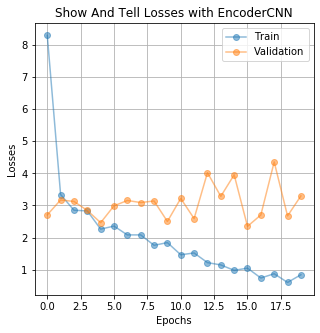

In [41]:
plot_losses(training_losses, val_losses, encoder)

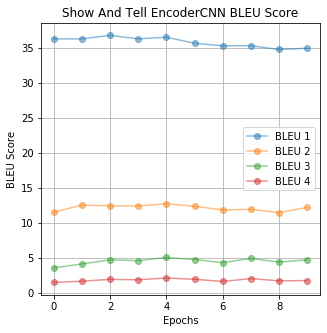

In [42]:
plot_bleu(bleu1_list, bleu2_list, bleu3_list, bleu4_list, encoder)

### 5.4 Test

In [43]:
def test(data_loader, encoder, decoder, criterion):
    
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    encoder.eval()
    decoder.eval()
    
    for i, (images,captions,lengths) in enumerate(data_loader):
        
        images = images.to(device)
        captions = captions.to(device)

        images, captions, lengths = sorting(images, captions, lengths)

        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        targets = targets.long()

        with torch.no_grad():
            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)
            
        if i % 1000 == 0:
            test_losses.append(loss.item())
  
    total, bleu1, bleu2, bleu3, bleu4 = 0, 0, 0, 0, 0

    with torch.no_grad():        
        hypothesis = []
        for i in range(len(test_image_list)):

            file=test_image_list[i]
            image = load_image('./Flickr8k/Flickr8k_resized_image/'+ str(file))
            
            sentence = sentence_generation(image, encoder, decoder)
            hypothesis.append([file,sentence])            
            org_sentence=annot[file]            
            generated=word_tokenize(str(sentence))

            actual=[]
            for j in org_sentence:
                actual.append(word_tokenize(j[0]))   

            score_bleu1 = sentence_bleu(actual, generated, weights=(1, 0, 0, 0))
            score_bleu2 = sentence_bleu(actual, generated, weights=(0, 1, 0, 0))
            score_bleu3 = sentence_bleu(actual, generated, weights=(0, 0, 1, 0))
            score_bleu4 = sentence_bleu(actual, generated, weights=(0, 0, 0, 1))
            
            bleu1 += score_bleu1
            bleu2 += score_bleu2    
            bleu3 += score_bleu3
            bleu4 += score_bleu4
            total +=1
            
    bleu1_list.append(100*bleu1/total)
    bleu2_list.append(100*bleu2/total)
    bleu3_list.append(100*bleu3/total)
    bleu4_list.append(100*bleu4/total)
    
    print("Test | Loss: {:.4f} | BLEU 1: {:.4f} | BLEU 2: {:.4f} | BLEU 3: {:.4f} | BLEU 4: {:.4f}\n".
          format(np.average(test_losses), np.average(bleu1_list), np.average(bleu2_list), np.average(bleu3_list), np.average(bleu4_list)))

In [44]:
best_epoch = 5

In [45]:
encoder_path = './Flickr8k/Flickr8k_checkpoints/{}_epoch_{}_lr_{}_bs_{}.model'.format(encoder.__class__.__name__, best_epoch, lr, batch_size)
decoder_path = './Flickr8k/Flickr8k_checkpoints/{}_epoch_{}_lr_{}_bs_{}.model'.format(decoder.__class__.__name__, best_epoch, lr, batch_size)

encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

test(test_loader, encoder, decoder, criterion)

Test | Loss: 2.5403 | BLEU 1: 35.8845 | BLEU 2: 12.1477 | BLEU 3: 4.4995 | BLEU 4: 1.7937



## 6. Inference

In [46]:
encoder_path = './Flickr8k/Flickr8k_checkpoints/{}_epoch_{}_lr_{}_bs_{}.model'.format(encoder.__class__.__name__, best_epoch, lr, batch_size)
decoder_path = './Flickr8k/Flickr8k_checkpoints/{}_epoch_{}_lr_{}_bs_{}.model'.format(decoder.__class__.__name__, best_epoch, lr, batch_size)
encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

<All keys matched successfully>

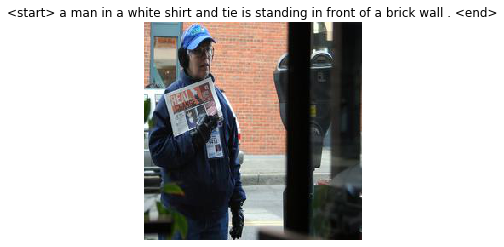

In [48]:
file = getRandomFile(test_image_list)
image = load_image('./Flickr8k/Flickr8k_resized_image/'+ str(file))

sentence = sentence_generation(image, encoder, decoder)
image = Image.open('./Flickr8k/Flickr8k_resized_image/'+ str(file))
plt.title(sentence)
plt.imshow(np.asarray(image))
plt.axis("off")
plt.savefig("./Flickr8k/Flickr8k_results/{}_Epoch_{}.png".format(encoder.__class__.__name__, best_epoch))